In [1]:
import pandas as pd

# Load the Microsoft stock prices dataset
file_path = 'MSFT.csv'
msft_data = pd.read_csv(file_path)

# Display the first few rows of the dataset
msft_data.head()


,Unnamed: 0,Date,Open,High,Low,Close,Volume
0,0,1986-03-13,0.054693,0.062736,0.054693,0.060055,1031788800
1,1,1986-03-14,0.060055,0.063272,0.060055,0.062199,308160000
2,2,1986-03-17,0.062199,0.063808,0.062199,0.063272,133171200
3,3,1986-03-18,0.063272,0.063808,0.061127,0.061663,67766400
4,4,1986-03-19,0.061663,0.062199,0.060055,0.060591,47894400


In [2]:
# Drop the unnecessary index column if it exists
msft_data.drop(columns=['Unnamed: 0'], inplace=True)

# Convert the 'Date' column to datetime format
msft_data['Date'] = pd.to_datetime(msft_data['Date'])

# Set the 'Date' column as the index for time series analysis
msft_data.set_index('Date', inplace=True)

# Sort the data by date to ensure chronological order
msft_data.sort_index(inplace=True)

# Handle missing values if any (e.g., forward fill or drop)
msft_data.fillna(method='ffill', inplace=True)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13164\2700569247.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  msft_data.fillna(method='ffill', inplace=True)


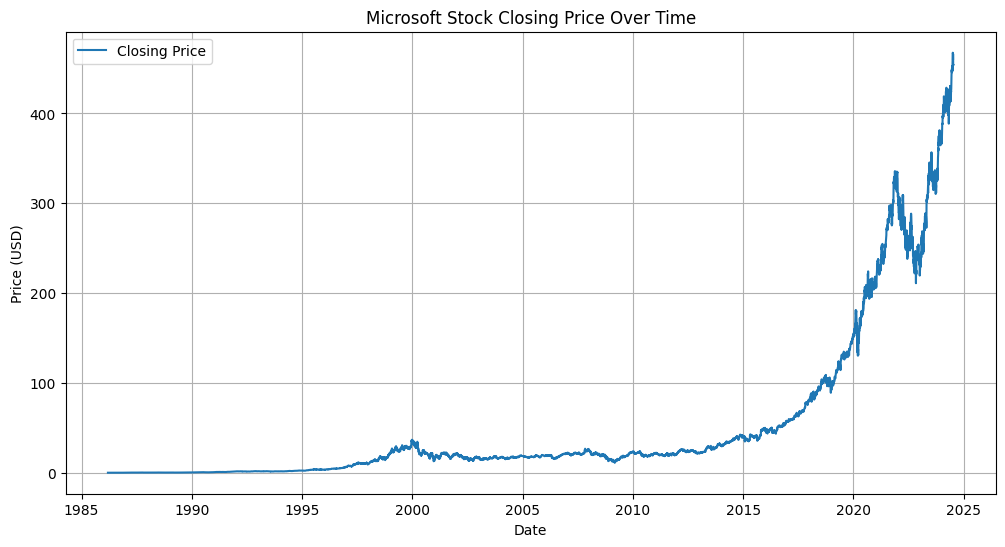

In [3]:
# Plotting the closing price over time
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(msft_data.index, msft_data['Close'], label='Closing Price')
plt.title('Microsoft Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

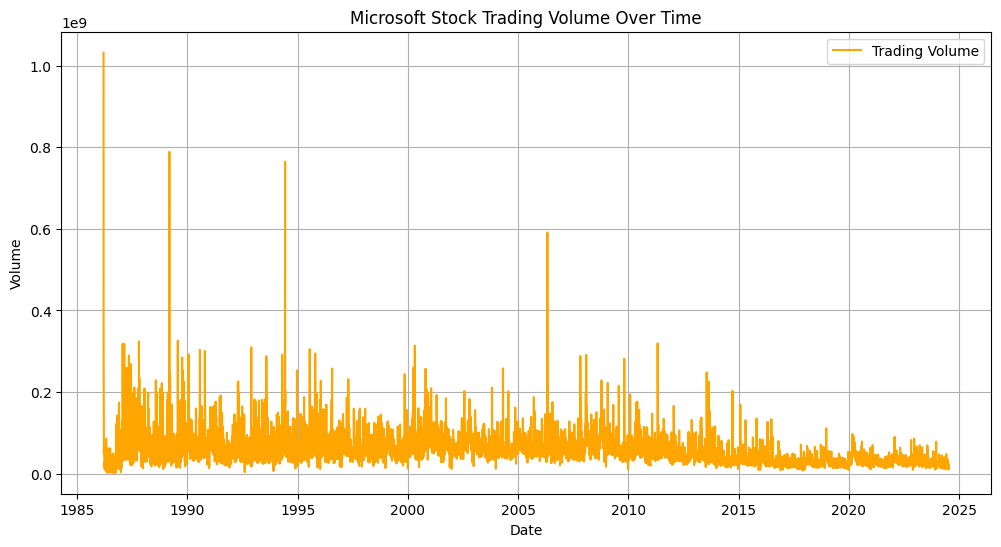

In [4]:
# Plotting the trading volume over time
plt.figure(figsize=(12, 6))
plt.plot(msft_data.index, msft_data['Volume'], label='Trading Volume', color='orange')
plt.title('Microsoft Stock Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid()
plt.show()

<Figure size 4000x600 with 0 Axes>

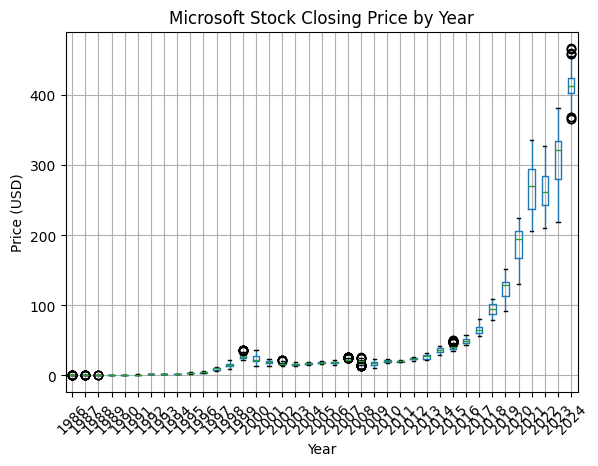

In [9]:
# Extracting the year from the index after fixing the datetime format
msft_data['Year'] = msft_data.index.year

# Plotting the boxplot for seasonal patterns - closing price by year
plt.figure(figsize=(40, 6))
msft_data.boxplot(column='Close', by='Year', grid=False)
plt.title('Microsoft Stock Closing Price by Year')
plt.suptitle('')
plt.xlabel('Year')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.grid()
plt.show()

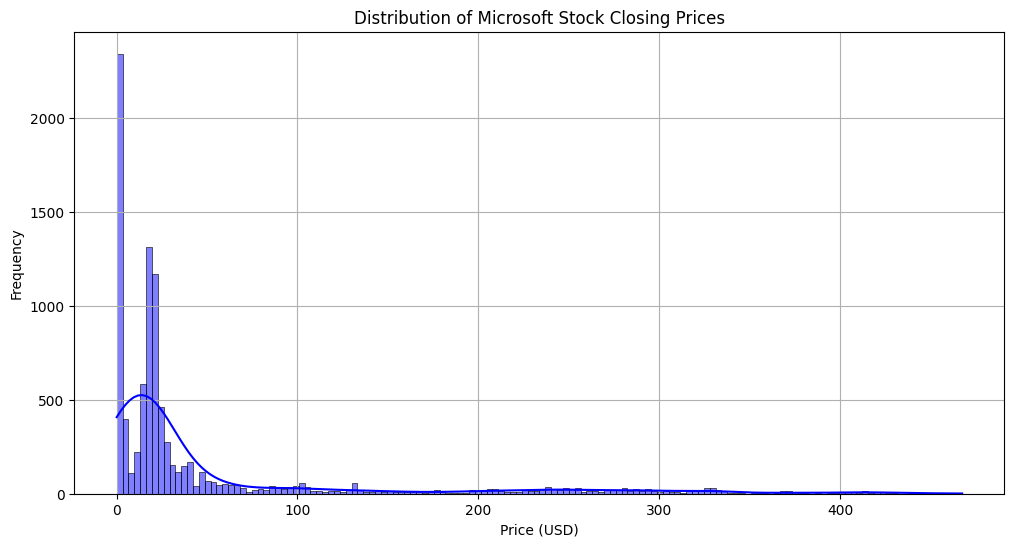

In [10]:
import seaborn as sns

# Plotting the distribution of the closing price using seaborn
plt.figure(figsize=(12, 6))
sns.histplot(msft_data['Close'], kde=True, color='blue')
plt.title('Distribution of Microsoft Stock Closing Prices')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.grid()
plt.show()


<Figure size 1400x1000 with 0 Axes>

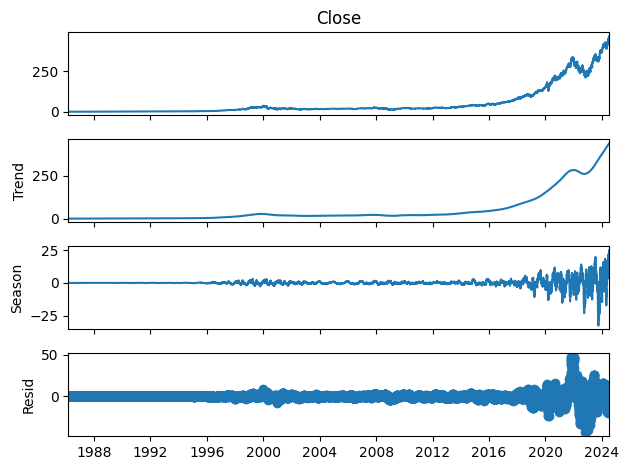

In [12]:
from statsmodels.tsa.seasonal import STL

# Perform Seasonal-Trend decomposition using STL with a period of 252 (for yearly seasonality in trading days)
stl = STL(msft_data['Close'], period=252)  # Setting period explicitly to match expected seasonality
result = stl.fit()

# Plot the STL decomposition components
plt.figure(figsize=(14, 10))
result.plot()
plt.show()


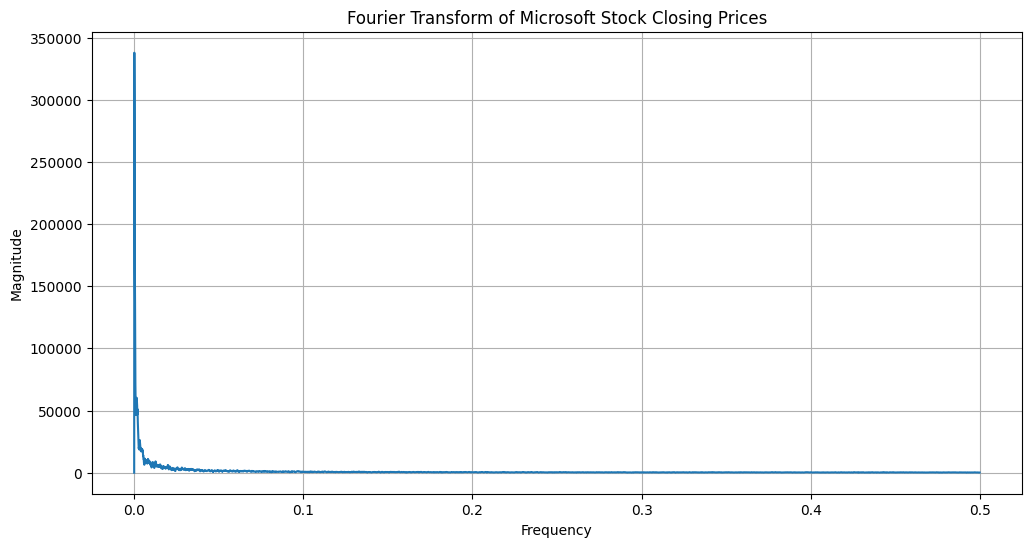

In [13]:
import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt

# Prepare data for Fourier Transform: Using closing prices and removing trend component
close_prices = msft_data['Close'] - msft_data['Close'].mean()  # Detrend by subtracting mean

# Convert closing prices to a NumPy array for Fourier Transform
close_prices_np = close_prices.values

# Perform Fourier Transform on the NumPy array
fft_result = fft(close_prices_np)

# Get the frequency and magnitude
n = len(close_prices_np)
frequencies = np.fft.fftfreq(n)
magnitudes = np.abs(fft_result)

# Plotting the Fourier Transform result
plt.figure(figsize=(12, 6))
plt.plot(frequencies[:n // 2], magnitudes[:n // 2])  # Plot only positive frequencies
plt.title('Fourier Transform of Microsoft Stock Closing Prices')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.grid()
plt.show()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13164\2287580650.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  msft_data['Close'].fillna(method='ffill', inplace=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13164\2287580650.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  msft_data['Close'].fillna(method='ffill', inplace=True)


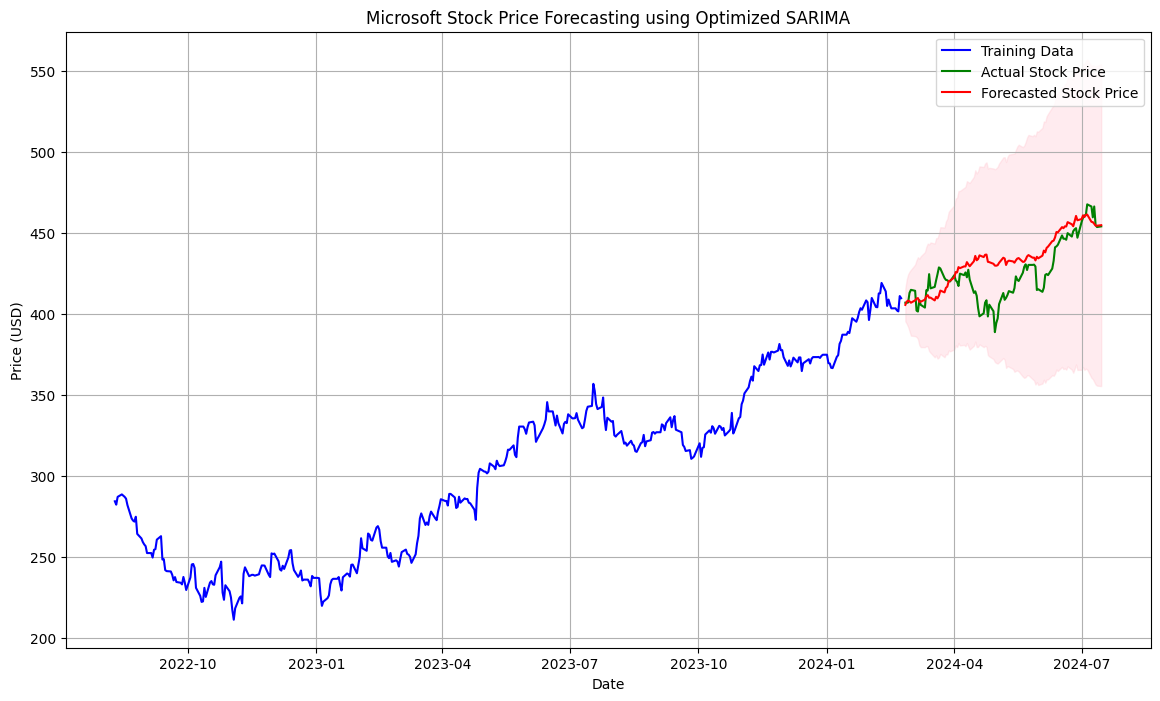

Root Mean Squared Error (RMSE) of the optimized SARIMA model: 15.25


In [15]:
# SARIMA FORECASTING
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

# Set the frequency of the index to 'B' (business days)
msft_data.index = pd.to_datetime(msft_data.index)
msft_data = msft_data.asfreq('B')

# Fill any missing values after setting the frequency (as holidays and weekends are now part of the index)
msft_data['Close'].fillna(method='ffill', inplace=True)

# Use a smaller subset of data for faster training (e.g., recent 2 years of data)
recent_data = msft_data['Close'][-2 * 252:]  # Use roughly the last 2 years (252 trading days per year)

# Split the data into training and testing sets (e.g., 80% train, 20% test)
train_size = int(len(recent_data) * 0.8)
train_data = recent_data[:train_size]
test_data = recent_data[train_size:]

# Define a simpler SARIMA model with smaller seasonal order
sarima_order = (1, 1, 1)  # ARIMA order (p, d, q)
seasonal_order = (0, 1, 1, 52)  # Seasonal order (P, D, Q, s) with s=52 for weekly seasonality

# Fit the SARIMA model on the training data
sarima_model = SARIMAX(train_data, order=sarima_order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
sarima_result = sarima_model.fit(disp=False)

# Make predictions on the test data
predictions = sarima_result.get_forecast(steps=len(test_data))
predicted_mean = predictions.predicted_mean
confidence_intervals = predictions.conf_int()

# Plot the actual vs. forecasted values
plt.figure(figsize=(14, 8))
plt.plot(train_data.index, train_data, label='Training Data', color='blue')
plt.plot(test_data.index, test_data, label='Actual Stock Price', color='green')
plt.plot(test_data.index, predicted_mean, label='Forecasted Stock Price', color='red')
plt.fill_between(test_data.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Microsoft Stock Price Forecasting using Optimized SARIMA')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

# Calculate the RMSE for model evaluation
rmse = np.sqrt(mean_squared_error(test_data, predicted_mean))
print(f'Root Mean Squared Error (RMSE) of the optimized SARIMA model: {rmse:.2f}')


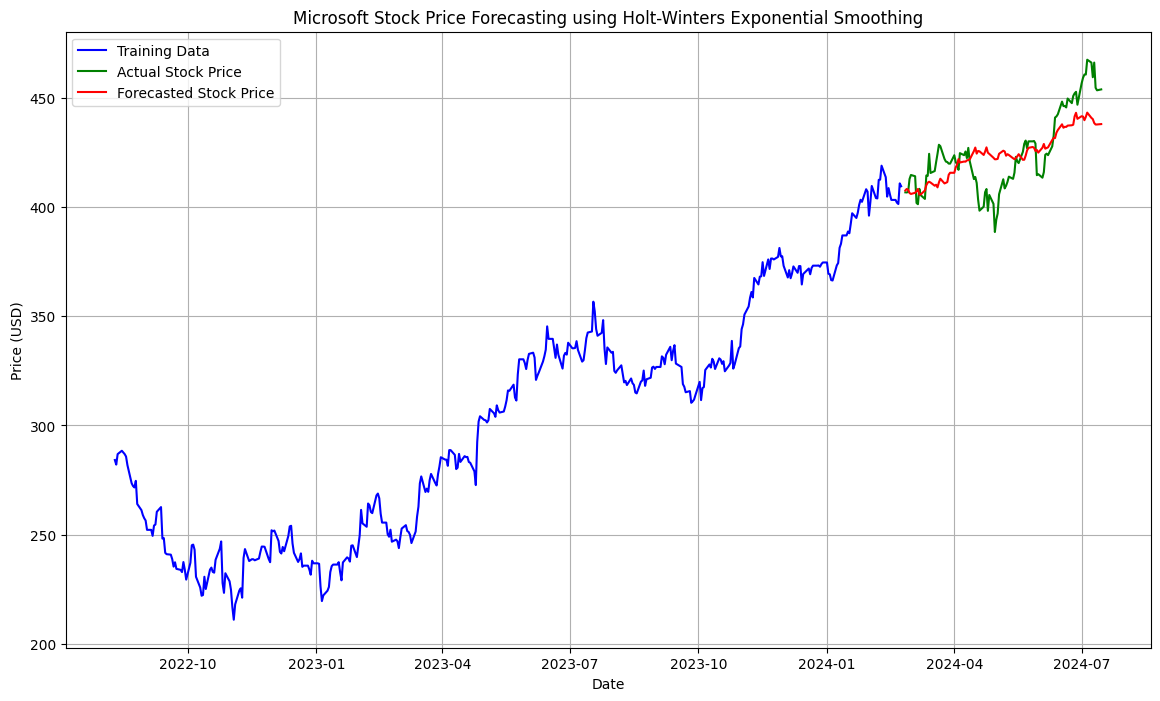

Root Mean Squared Error (RMSE) of the Holt-Winters model: 12.93


In [16]:
# Holt-Winters Exponential Smoothing.
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import numpy as np

# Use a smaller subset of data for faster training (e.g., recent 2 years of data)
recent_data = msft_data['Close'][-2 * 252:]  # Use roughly the last 2 years (252 trading days per year)

# Split the data into training and testing sets (e.g., 80% train, 20% test)
train_size = int(len(recent_data) * 0.8)
train_data = recent_data[:train_size]
test_data = recent_data[train_size:]

# Fit the Holt-Winters Exponential Smoothing model
holt_winters_model = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=52)
holt_winters_result = holt_winters_model.fit()

# Make predictions on the test data
holt_winters_forecast = holt_winters_result.forecast(steps=len(test_data))

# Plot the actual vs. forecasted values
plt.figure(figsize=(14, 8))
plt.plot(train_data.index, train_data, label='Training Data', color='blue')
plt.plot(test_data.index, test_data, label='Actual Stock Price', color='green')
plt.plot(test_data.index, holt_winters_forecast, label='Forecasted Stock Price', color='red')
plt.title('Microsoft Stock Price Forecasting using Holt-Winters Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

# Calculate the RMSE for model evaluation
rmse_hw = np.sqrt(mean_squared_error(test_data, holt_winters_forecast))
print(f'Root Mean Squared Error (RMSE) of the Holt-Winters model: {rmse_hw:.2f}')


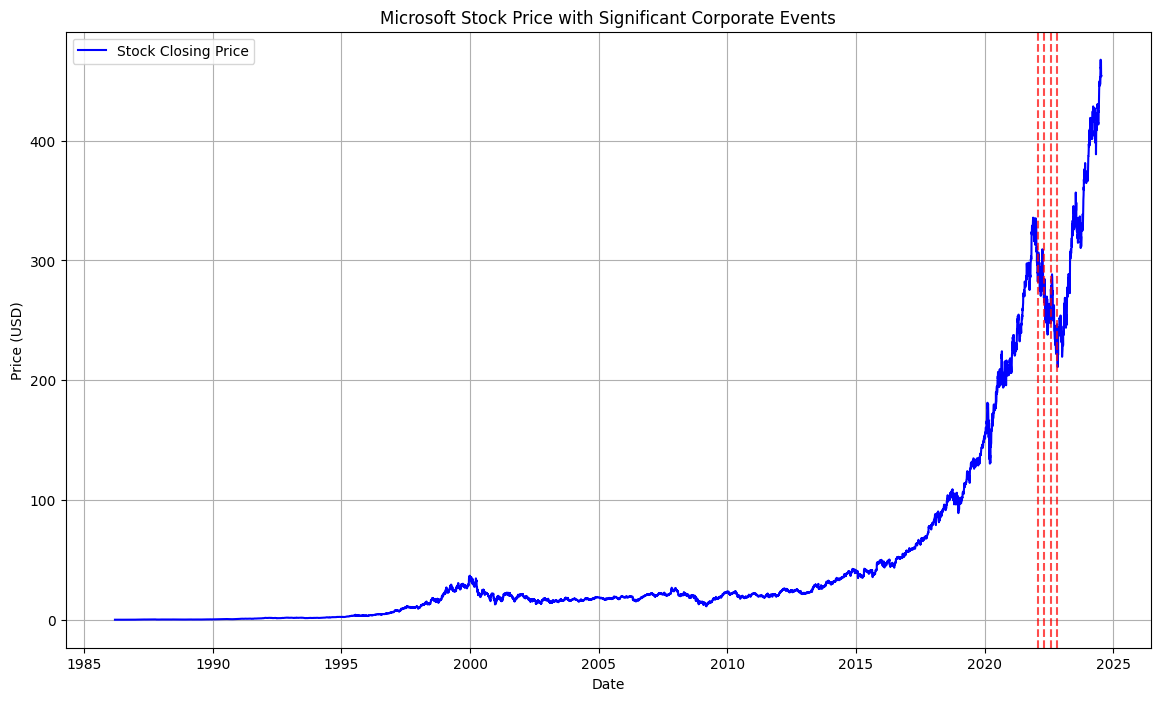

In [18]:
# Q2
#  Correlating Patterns with Microsoft’s Corporate Calendar

# List of significant events (example dates for Microsoft’s events)
significant_events = [
    '2022-01-25',  # Earnings report
    '2022-04-26',  # Earnings report
    '2022-07-26',  # Earnings report
    '2022-10-25',  # Product launch or other significant event
]

# Convert the events to datetime for plotting
events_dates = pd.to_datetime(significant_events)

# Plotting Microsoft stock prices with significant events
plt.figure(figsize=(14, 8))
plt.plot(msft_data.index, msft_data['Close'], label='Stock Closing Price', color='blue')
for event in events_dates:
    plt.axvline(event, color='red', linestyle='--', alpha=0.7)
plt.title('Microsoft Stock Price with Significant Corporate Events')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()


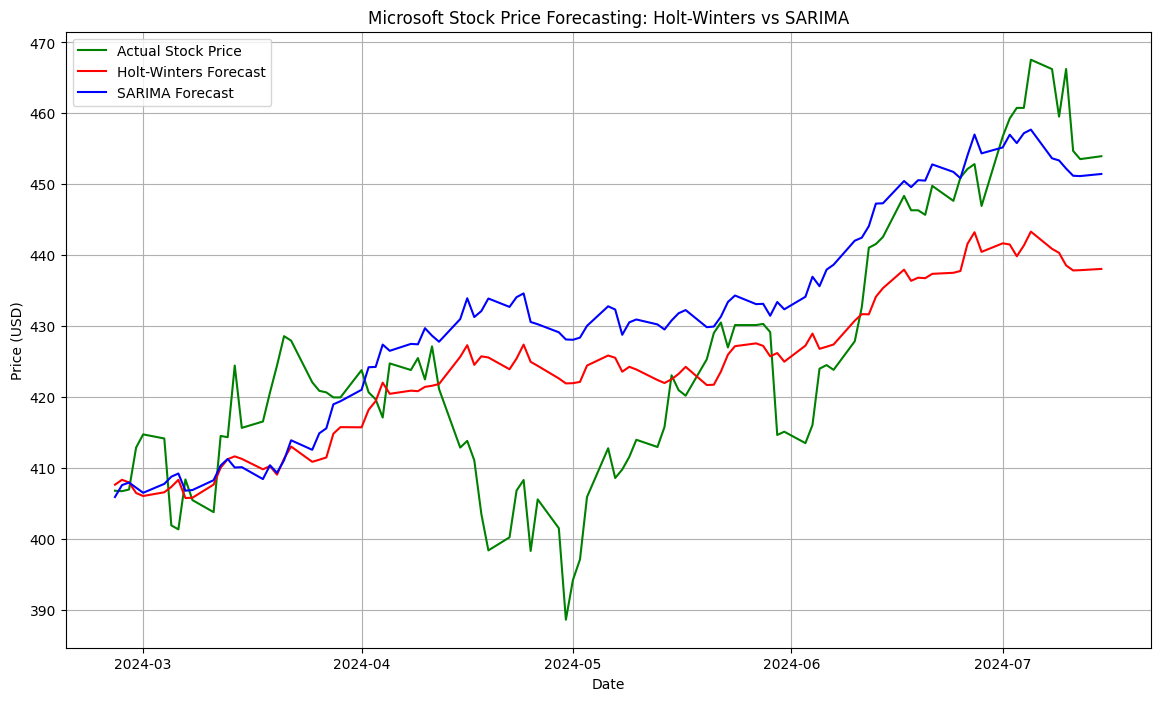

Holt-Winters Model RMSE: 12.93
SARIMA Model RMSE: 14.16


In [20]:
 # Evaluating Whether Identifying Patterns Improves Forecasting Accuracy


from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Use a smaller subset of data for faster training (e.g., recent 2 years of data)
recent_data = msft_data['Close'][-2 * 252:]  # Use roughly the last 2 years (252 trading days per year)

# Split the data into training and testing sets (e.g., 80% train, 20% test)
train_size = int(len(recent_data) * 0.8)
train_data = recent_data[:train_size]
test_data = recent_data[train_size:]

# Fit the Holt-Winters Exponential Smoothing model
holt_winters_model = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=52)
holt_winters_result = holt_winters_model.fit()

# Make predictions on the test data using Holt-Winters
holt_winters_forecast = holt_winters_result.forecast(steps=len(test_data))

# Fit the SARIMA model (p, d, q) x (P, D, Q, s)
sarima_model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
sarima_result = sarima_model.fit(disp=False)

# Make predictions on the test data using SARIMA
sarima_forecast = sarima_result.get_forecast(steps=len(test_data)).predicted_mean

# Plot the actual vs. forecasted values for both models
plt.figure(figsize=(14, 8))
plt.plot(test_data.index, test_data, label='Actual Stock Price', color='green')
plt.plot(test_data.index, holt_winters_forecast, label='Holt-Winters Forecast', color='red')
plt.plot(test_data.index, sarima_forecast, label='SARIMA Forecast', color='blue')
plt.title('Microsoft Stock Price Forecasting: Holt-Winters vs SARIMA')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

# Calculate RMSE for both models
rmse_hw = np.sqrt(mean_squared_error(test_data, holt_winters_forecast))
rmse_sarima = np.sqrt(mean_squared_error(test_data, sarima_forecast))

print(f'Holt-Winters Model RMSE: {rmse_hw:.2f}')
print(f'SARIMA Model RMSE: {rmse_sarima:.2f}')

